In [5]:
from alltools.machine_learning.convtools import compute_output_shape, conviter, align_kernel
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
X = np.array([1, 0, 4, 2, 125, 67])
w = np.array([1, 2, 1])

np.convolve(X, w, 'same')

array([  2,   5,  10, 133, 319, 259])

In [4]:
X = np.arange(100)

for p, q, k in conviter((100,), 10, 0, 10):
    print(X[p])

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39]
[40 41 42 43 44 45 46 47 48 49]
[50 51 52 53 54 55 56 57 58 59]
[60 61 62 63 64 65 66 67 68 69]
[70 71 72 73 74 75 76 77 78 79]
[80 81 82 83 84 85 86 87 88 89]
[90 91 92 93 94 95 96 97 98 99]


In [405]:
def gaussian_random_walk(n: int, stepsize: float = 1.0) -> np.ndarray:
    """
    Generates a Gaussian random walk for a given number of points using numpy.

    Args:
        n: the number of points in the random walk
        stepsize: the standard deviation of the Gaussian distribution used to generate the random steps (default is 1.0)

    Returns:
        A numpy array of shape (n, 2) representing the x and y coordinates of the random walk.
    """
    # Generate random steps using a Gaussian distribution
    steps = np.random.normal(loc=0, scale=stepsize, size=(n, 2))

    # Compute the coordinates of the random walk by cumulatively summing the steps
    walk = np.cumsum(steps, axis=0)

    return walk

In [78]:

# X = np.random.random((100,))
X = gaussian_random_walk(200).T[0]
window_size = 10
compression_ratio = .5
w = 2*np.random.random((window_size, int(window_size*compression_ratio))) - 1
overlap = 0
# X shape: n_times x ...


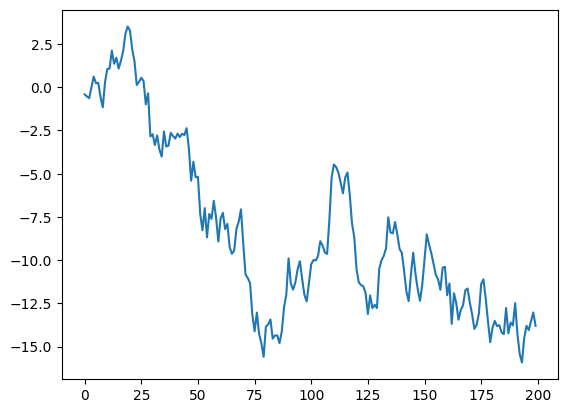

In [60]:
plt.plot(X)

In [63]:
X_part1 = X[:-(window_size - overlap)]
X_part2 = X[window_size - overlap:]
compute_output_shape(X_part2.shape, window_size, 2*overlap, window_size)

(19,)

In [273]:
import tensorflow as tf

class LayerA(tf.keras.layers.Layer):
  def __init__(self, units, window_size, overlap=0, paddings=0,
               strides=None, compression_ratio=1.0, activation=None, use_bias=True,
               kernel_initializer='glorot_uniform', bias_initializer='zeros',
               kernel_regularizer=None, bias_regularizer=None,
               kernel_constraint=None, bias_constraint=None, **kwargs):
    super().__init__(**kwargs)
    self.units = units
    self.window_size = window_size
    self.overlap = overlap
    self.paddings = paddings
    if strides is not None:
      self.strides = strides
    else:
      self.strides = window_size
    self.compression_ratio = compression_ratio
    self.activation = activation
    self.use_bias = use_bias
    self.kernel_initializer = kernel_initializer
    self.bias_initializer = bias_initializer
    self.kernel_regularizer = kernel_regularizer
    self.bias_regularizer = bias_regularizer
    self.kernel_constraint = kernel_constraint
    self.bias_constraint = bias_constraint

  def build(self, input_shape):
    # Create a trainable weight variable for the kernel
    self.kernel = self.add_weight(
        name='kernel',
        shape=[self.window_size, int(self.window_size*self.compression_ratio), self.units],
        initializer=self.kernel_initializer,
        regularizer=self.kernel_regularizer,
        constraint=self.kernel_constraint,
        trainable=True
    )

    if self.use_bias:
      # Create a trainable bias variable for the bias
      self.bias = self.add_weight(
          name='bias',
          shape=[self.units],
          initializer=self.bias_initializer,
          regularizer=self.bias_regularizer,
          constraint=self.bias_constraint,
          trainable=True
      )
    else:
      self.bias = None

  def call(self, inputs):
    # inputs shape: (batch_size, 1, times, 1)
    output = list()
    for batch in inputs:
      X_part1 = batch[0, :-(self.window_size - self.overlap), 0] # shape: (1, times)
      X_part2 = batch[0, self.window_size - self.overlap:, 0]
      assert X_part1.shape == X_part2.shape, 'Windowed sequence is corrupted'
      # out = tf.Variable(tf.zeros((*compute_output_shape(X_part2.shape, self.window_size, self.paddings, self.strides), self.units)))
      # print(compute_output_shape(X_part2.shape, self.window_size, self.paddings, self.strides), self.units)
      out = list()
      for p, q, k in conviter(X_part2.shape, self.window_size, self.paddings, self.strides):
        # print(p)
        # print(tf.expand_dims(X_part1[p], 0).shape, tf.transpose(self.kernel[k], (2, 0, 1)).shape, end='')
        # self.kernel[k].shape is (current_window x compressed_size x n_units) -> (n_units x current_window x compressed_size)
        # print((tf.squeeze(tf.expand_dims(X_part1[p], 0) @ tf.transpose(self.kernel[k], (2, 0, 1)), axis=1)).shape)
        proj1 = tf.transpose(tf.squeeze(tf.expand_dims(X_part1[p], 0) @ tf.transpose(self.kernel[k], (2, 0, 1)), axis=1), (1, 0)) # shape: compressed_size x units
        proj2 = tf.transpose(tf.squeeze(tf.expand_dims(X_part2[p], 0) @ tf.transpose(self.kernel[k], (2, 0, 1)), axis=1), (1, 0))
        # print(proj1.shape)
        cov = tf.expand_dims(tf.reduce_mean(
          (proj1 - tf.reduce_mean(proj1, axis=0))*(proj2 - tf.reduce_mean(proj2, axis=0)), axis=0
        ), 0) # shape: 1 x units
        # print(cov.shape, self.bias.shape)
        if self.use_bias:
          cov = tf.nn.bias_add(cov, self.bias) # shape: 1 x units
        # out[k] = cov
        # out[k].assign(cov)
        out.append(cov)
      out = tf.stack(out)
      # print(out.shape)
      if self.activation is not None:
        # Apply the activation function to the output
        out = self.activation(out)

      output.append(out)

    return tf.stack(output, axis=0) # (batch_size, 1, conv_output_size, n_units)


In [ ]:
import tensorflow as tf
import numpy as np

class LayerA(tf.keras.layers.Layer):
  def __init__(self, units, window_size, overlap=0, paddings=0,
               strides=None, compression_ratio=1.0, activation=None, use_bias=True,
               kernel_initializer='glorot_uniform', bias_initializer='zeros',
               kernel_regularizer=None, bias_regularizer=None,
               kernel_constraint=None, bias_constraint=None, **kwargs):
    super().__init__(**kwargs)
    self.units = units
    self.window_size = window_size
    self.overlap = overlap
    self.paddings = paddings
    if strides is not None:
      self.strides = strides
    else:
      self.strides = window_size
    self.compression_ratio = compression_ratio
    self.activation = activation
    self.use_bias = use_bias
    self.kernel_initializer = kernel_initializer
    self.bias_initializer = bias_initializer
    self.kernel_regularizer = kernel_regularizer
    self.bias_regularizer = bias_regularizer
    self.kernel_constraint = kernel_constraint
    self.bias_constraint = bias_constraint

  def build(self, input_shape):
    # Create a trainable weight variable for the kernel
    self.kernel = self.add_weight(
        name='kernel',
        shape=[self.window_size, int(self.window_size*self.compression_ratio), self.units],
        initializer=self.kernel_initializer,
        regularizer=self.kernel_regularizer,
        constraint=self.kernel_constraint,
        trainable=True
    )

    if self.use_bias:
      # Create a trainable bias variable for the bias
      self.bias = self.add_weight(
          name='bias',
          shape=[self.units],
          initializer=self.bias_initializer,
          regularizer=self.bias_regularizer,
          constraint=self.bias_constraint,
          trainable=True
      )
    else:
      self.bias = None

  def call(self, inputs):
    # inputs shape: (batch_size, 1, times, 1)

    X_part1 = inputs[:, 0, :-(self.window_size - self.overlap), 0] # shape: (batches, times)
    X_part2 = inputs[:, 0, self.window_size - self.overlap:, 0]
    assert X_part1.shape == X_part2.shape, 'Windowed sequence is corrupted'
    print(X_part1.shape)
    # out = tf.Variable(tf.zeros((*compute_output_shape(X_part2.shape, self.window_size, self.paddings, self.strides), self.units)))
    # print(compute_output_shape(X_part2.shape, self.window_size, self.paddings, self.strides), self.units)
    out = list()
    for p, q, k in conviter(X_part2.shape, self.window_size, self.paddings, self.strides):
      # self.kernel[k].shape is (current_window x compressed_size x n_units) -> (n_units x current_window x compressed_size)
      print(self.kernel[k].shape, k)
      proj1 = tf.transpose(tf.squeeze(tf.expand_dims(X_part1[p], 0) @ tf.transpose(self.kernel[k], (2, 0, 1)), axis=1), (1, 0)) # shape: compressed_size x units
      proj2 = tf.transpose(tf.squeeze(tf.expand_dims(X_part2[p], 0) @ tf.transpose(self.kernel[k], (2, 0, 1)), axis=1), (1, 0))
      cov = tf.expand_dims(tf.reduce_mean(
        (proj1 - tf.reduce_mean(proj1, axis=0))*(proj2 - tf.reduce_mean(proj2, axis=0)), axis=0
      ), 0) # shape: 1 x units
      if self.use_bias:
        cov = tf.nn.bias_add(cov, self.bias) # shape: 1 x units
      out.append(cov)
    out = tf.stack(out)
    if self.activation is not None:
      # Apply the activation function to the output
      out = self.activation(out)

    return tf.stack(out, axis=0) # (batch_size, 1, conv_output_size, n_units)


inputs = 2*np.random.random((20, 1, 201, 1)) - 1
l = LayerA(2, 10)
l(inputs).shape

In [2]:
def moving_average(data: np.ndarray, kernel_size: int = 20) -> np.ndarray:
    """
    Compute the moving average of a given data array.

    Parameters
    ----------
    data : np.ndarray
        The data array.
    kernel_size : int
        The size of the kernel.

    Returns
    -------
    np.ndarray
        The moving average of the data array.
    """
    kernel = np.ones(kernel_size) / kernel_size
    return np.convolve(data, kernel, mode='same')

In [232]:

class MyModel(tf.keras.Model):
    def __init__(self, units, window_size, overlap=0, paddings=0,
               strides=None, compression_ratio=1.0, activation=None, use_bias=True,
               kernel_initializer='glorot_uniform', bias_initializer='zeros',
               kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
               kernel_constraint=None, bias_constraint=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.window_size = window_size
        self.overlap = overlap
        self.paddings = paddings
        if strides is not None:
            self.strides = strides
        else:
            self.strides = window_size
        self.compression_ratio = compression_ratio
        self.activation = activation
        self.use_bias = use_bias
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.kernel_regularizer = kernel_regularizer
        self.bias_regularizer = bias_regularizer
        self.activity_regularizer = activity_regularizer
        self.kernel_constraint = kernel_constraint
        self.bias_constraint = bias_constraint
        self.projections = [
            tf.keras.layers.Dense(
                int(self.window_size*self.compression_ratio),
                use_bias=self.use_bias,
                kernel_initializer=self.kernel_initializer,
                bias_initializer=self.bias_initializer,
                kernel_regularizer=self.kernel_regularizer,
                bias_regularizer=self.bias_regularizer,
                activity_regularizer=self.activity_regularizer,
                kernel_constraint=self.kernel_constraint,
                bias_constraint=self.bias_constraint
            ) for _ in range(self.units)
        ]
    def call(self, inputs):
        X_part1 = inputs[:, 0, :-(self.window_size - self.overlap), 0] # shape: (batches, times)
        X_part2 = inputs[:, 0, self.window_size - self.overlap:, 0]
        assert X_part1.shape == X_part2.shape, 'Windowed sequence is corrupted'
        out = list()
        # Q = tf.Variable(tf.zeros([inputs.shape[0], self.units, *compute_output_shape((X_part2.shape[1], 1), self.window_size, self.paddings, self.strides)]))
        outputs = list()
        for p, q, k in conviter((X_part2.shape[1], X_part2.shape[0]), self.window_size, self.paddings, self.strides):
            if p[0].start == 0:
                paddings = tf.constant([[0, 0,], [self.window_size - (p[0].stop - p[0].start), 0]])
            else:
                paddings = tf.constant([[0, 0,], [0, self.window_size - (p[0].stop - p[0].start)]])
            win1 = tf.pad(X_part1[p[::-1]], paddings, 'CONSTANT') # shape: (n_batches, window_size)
            win2 = tf.pad(X_part2[p[::-1]], paddings, 'CONSTANT')
            proj1 = tf.stack([unit(win1) for unit in self.projections], 1) # shape: (n_batches, n_units, window_size)
            proj2 = tf.stack([unit(win2) for unit in self.projections], 1)
            cov = tf.reduce_mean((proj1 - tf.reduce_mean(proj1, -1, keepdims=True))*(proj2 - tf.reduce_mean(proj2, -1, keepdims=True)), -1) # shape: (n_batches, n_units)
            outputs.append(cov)
        if self.activation:
            return self.activation(tf.stack(outputs, 1))
        else:
            return tf.stack(outputs, 1) # shape: (n_batches, n_outputs, n_units)

model = MyModel(1, 10, 4, 2, 5)
inputs = 2*np.random.random((300, 1, 101, 1)) - 1
# y = 2*np.random.random((3, 9, 2)) - 1
y = 10*np.ones((300, 18, 1))
model.compile(optimizer="Adam", loss="mse", metrics=["mae",])
model.fit(inputs, y, epochs=500)

Epoch 1/500
10/10 [==============================] - 4s 3ms/step - loss: 100.6064 - mae: 10.0291
Epoch 2/500
10/10 [==============================] - 0s 2ms/step - loss: 100.4713 - mae: 10.0224
Epoch 3/500
10/10 [==============================] - 0s 2ms/step - loss: 100.3375 - mae: 10.0157
Epoch 4/500
10/10 [==============================] - 0s 2ms/step - loss: 100.2015 - mae: 10.0089
Epoch 5/500
10/10 [==============================] - 0s 3ms/step - loss: 100.0642 - mae: 10.0021
Epoch 6/500
10/10 [==============================] - 0s 2ms/step - loss: 99.9225 - mae: 9.9950
Epoch 7/500
10/10 [==============================] - 0s 2ms/step - loss: 99.7738 - mae: 9.9875
Epoch 8/500
10/10 [==============================] - 0s 3ms/step - loss: 99.6169 - mae: 9.9797
Epoch 9/500
10/10 [==============================] - 0s 2ms/step - loss: 99.4507 - mae: 9.9713
Epoch 10/500
10/10 [==============================] - 0s 3ms/step - loss: 99.2747 - mae: 9.9624
Epoch 11/500
10/10 [===================

In [583]:
def gen_random_data(
    batch_size,
    n_timepoints,
    out_dim,
    ma1=20,
    ma2=5
):
    data = list()
    labels = list()

    for _ in range(batch_size):
        X = 2*np.random.random((n_timepoints,)) - 1
        # X = gaussian_random_walk(n_timepoints).T[0]
        Y = np.zeros(out_dim)
        X = moving_average(X, ma1)
        start = np.random.randint(0, n_timepoints//4) + 250
        dist = np.random.randint(n_timepoints//10, n_timepoints//4)
        stop = start + dist
        X[start:stop] += moving_average(2*np.random.random((stop - start)) - 1, ma2)
        # X[start:stop] = gaussian_random_walk(stop - start, 5).T[0]
        ratio = n_timepoints//out_dim
        Y[start//ratio:stop//ratio] = 1
        data.append(np.expand_dims(X, (0, -1)))
        labels.append(Y)

    return np.array(data), np.array(labels)

In [584]:
genargs = (500, 1000, 50,)
data, labels = gen_random_data(*genargs)
test_data, test_labels = gen_random_data(*genargs)

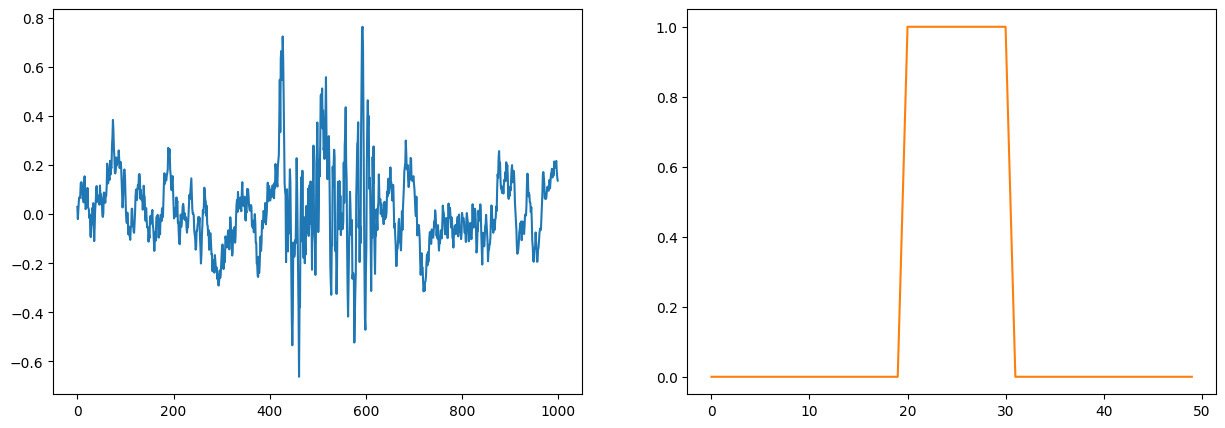

In [595]:
i = np.random.randint(500)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(np.squeeze(data[i]))
ax2.plot(np.squeeze(labels[i]), color='tab:orange')

In [638]:

class MyModel2(tf.keras.Model):

  def __init__(self, input_dim, out_dim, overlap_ratio = 0., stride = None):
    super().__init__()
    window_size = input_dim//(2*out_dim)
    overlap = int(overlap_ratio*window_size)
    if stride is None:
      stride = window_size
    self.timesel = MyModel(1, window_size, overlap, 0, stride, use_bias=False)
    self.dense = tf.keras.layers.Dense(out_dim, activation='sigmoid')

  def call(self, inputs):
    return self.dense(tf.squeeze(self.timesel(inputs)))


In [639]:
model = MyModel2(1000, 50)
model.compile(optimizer="Adam", loss="mse", metrics=["mae",])
model.fit(
    data, labels,
    epochs=500, batch_size=200,
    validation_split=.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
)

Epoch 1/500
2/2 [==============================] - 16s 5s/step - loss: 0.2495 - mae: 0.4994 - val_loss: 0.2492 - val_mae: 0.4991
Epoch 2/500
2/2 [==============================] - 1s 647ms/step - loss: 0.2487 - mae: 0.4986 - val_loss: 0.2485 - val_mae: 0.4984
Epoch 3/500
2/2 [==============================] - 1s 760ms/step - loss: 0.2479 - mae: 0.4977 - val_loss: 0.2477 - val_mae: 0.4976
Epoch 4/500
2/2 [==============================] - 1s 730ms/step - loss: 0.2470 - mae: 0.4969 - val_loss: 0.2469 - val_mae: 0.4967
Epoch 5/500
2/2 [==============================] - 1s 799ms/step - loss: 0.2461 - mae: 0.4960 - val_loss: 0.2461 - val_mae: 0.4959
Epoch 6/500
2/2 [==============================] - 1s 672ms/step - loss: 0.2452 - mae: 0.4950 - val_loss: 0.2452 - val_mae: 0.4950
Epoch 7/500
2/2 [==============================] - 1s 682ms/step - loss: 0.2443 - mae: 0.4941 - val_loss: 0.2443 - val_mae: 0.4941
Epoch 8/500
2/2 [==============================] - 1s 623ms/step - loss: 0.2433 - mae

In [640]:
preds = model(test_data)

Text(0.5, 1.0, 'Sample 385')

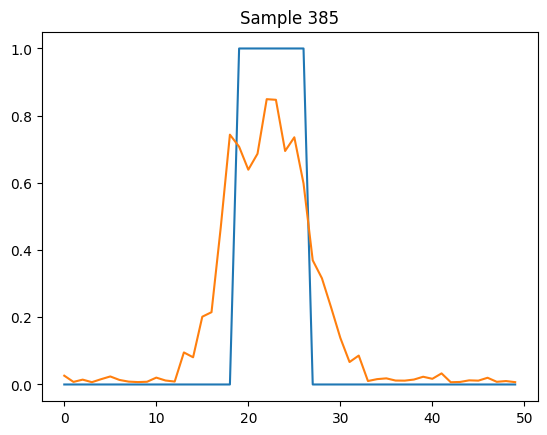

In [645]:
i = np.random.randint(len(preds))
plt.plot(test_labels[i])
plt.plot(preds[i])
plt.title(f'Sample {i}')

In [260]:
gradients

[None, None]

In [277]:
# inputs = tf.keras.Input(shape=(20, 1, 201, 1), name='input')
inputs = 2*np.random.random((20, 1, 201, 1)) - 1
l = LayerA(1, 10)
outputs = l(inputs)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="Adam", loss="mse", metrics=["mae", "acc"])
X = 2*np.random.random((20, 1, 201, 1)) - 1
y = np.random.random((20, 1, 19, 1))
model.fit(X, y,)


ValueError: Found unexpected instance while processing input tensors for keras functional model. Expecting KerasTensor which is from tf.keras.Input() or output from keras layer call(). Got: [[[[-0.52706782]
   [-0.42110578]
   [-0.16575351]
   ...
   [ 0.11515421]
   [ 0.93076163]
   [-0.06811255]]]


 [[[-0.95899801]
   [ 0.35166325]
   [ 0.30936851]
   ...
   [ 0.14367651]
   [ 0.08023092]
   [-0.20500205]]]


 [[[ 0.31840883]
   [ 0.22809087]
   [-0.22977113]
   ...
   [ 0.28115311]
   [-0.65130602]
   [-0.44980368]]]


 ...


 [[[-0.9797202 ]
   [-0.79324404]
   [ 0.1258055 ]
   ...
   [ 0.11974339]
   [-0.04156586]
   [ 0.16800096]]]


 [[[-0.89823694]
   [-0.18616756]
   [ 0.75570027]
   ...
   [ 0.2395808 ]
   [-0.61740159]
   [ 0.49677449]]]


 [[[ 0.96565907]
   [ 0.79746253]
   [ 0.73942632]
   ...
   [ 0.78885913]
   [ 0.47747406]
   [ 0.57074019]]]]

In [261]:

custom_layer = LayerA(1, 10)
custom_layer(inputs).shape

TensorShape([20, 1, 19, 1])

In [221]:
l = LayerA(
    1,
    10,
)
out = l(X)

In [222]:
out.shape

TensorShape([20, 1, 19, 1])

In [ ]:
out

(8, 5) slice(-8, None, None)
0.10010180755628642


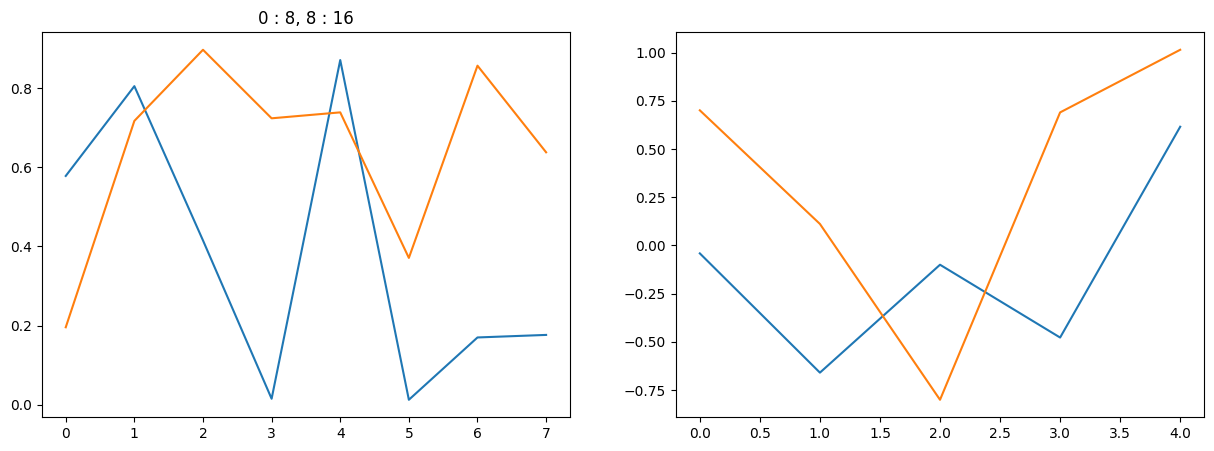

(10, 5) slice(None, 10, None)
0.5541302436218046


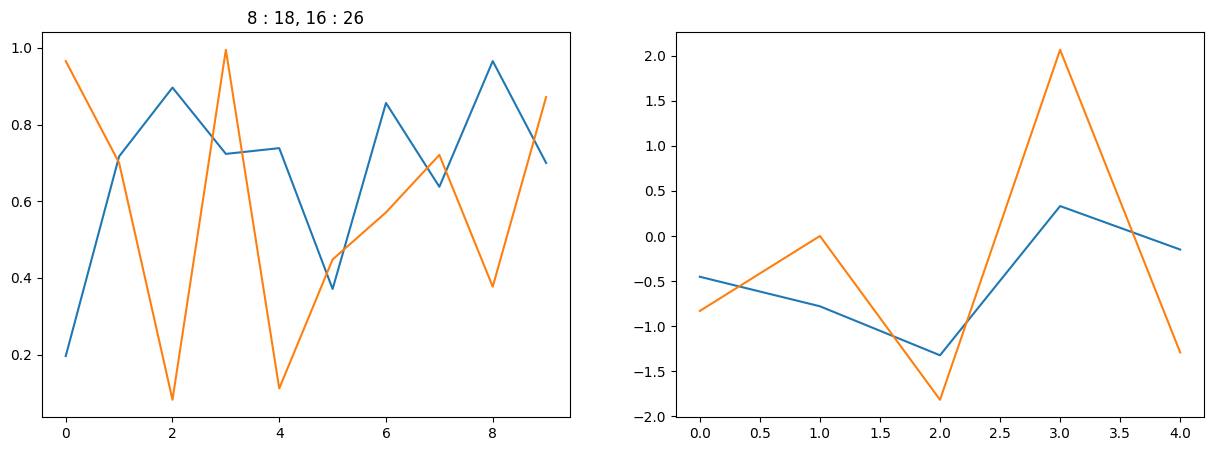

(10, 5) slice(None, 10, None)
-0.028976153651919717


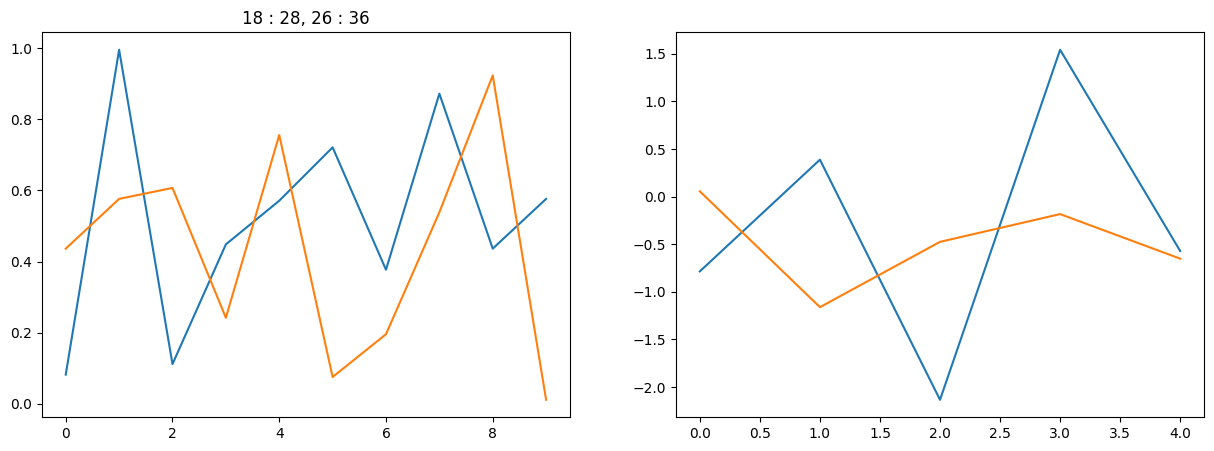

(10, 5) slice(None, 10, None)
0.3951963055021041


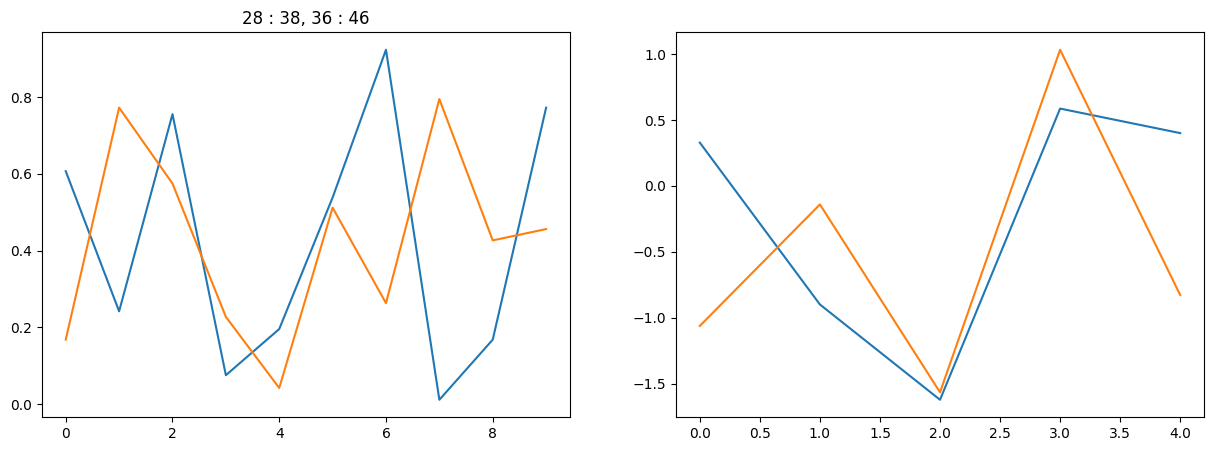

(10, 5) slice(None, 10, None)
0.6561773272585611


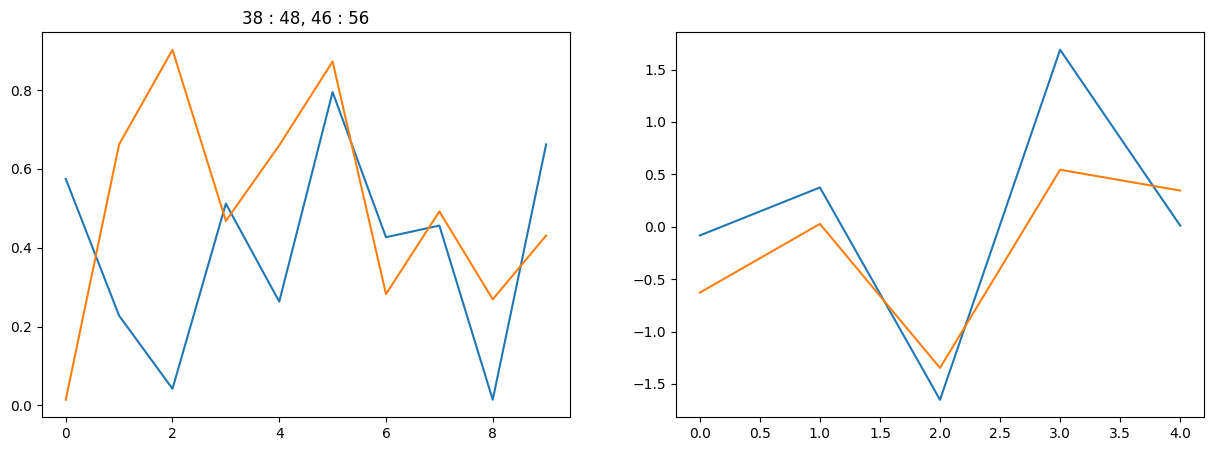

(10, 5) slice(None, 10, None)
0.5453743044480036


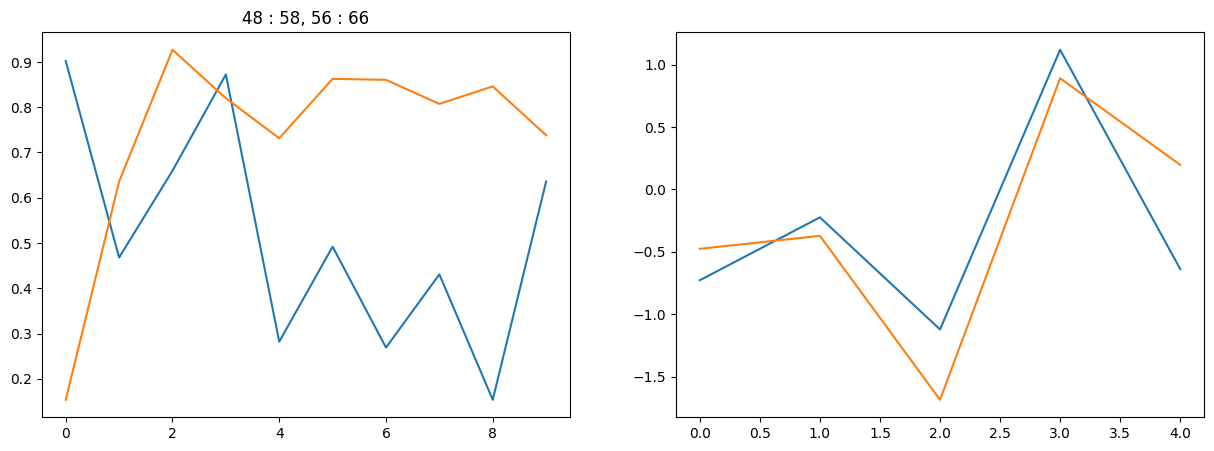

(10, 5) slice(None, 10, None)
0.7619135065698928


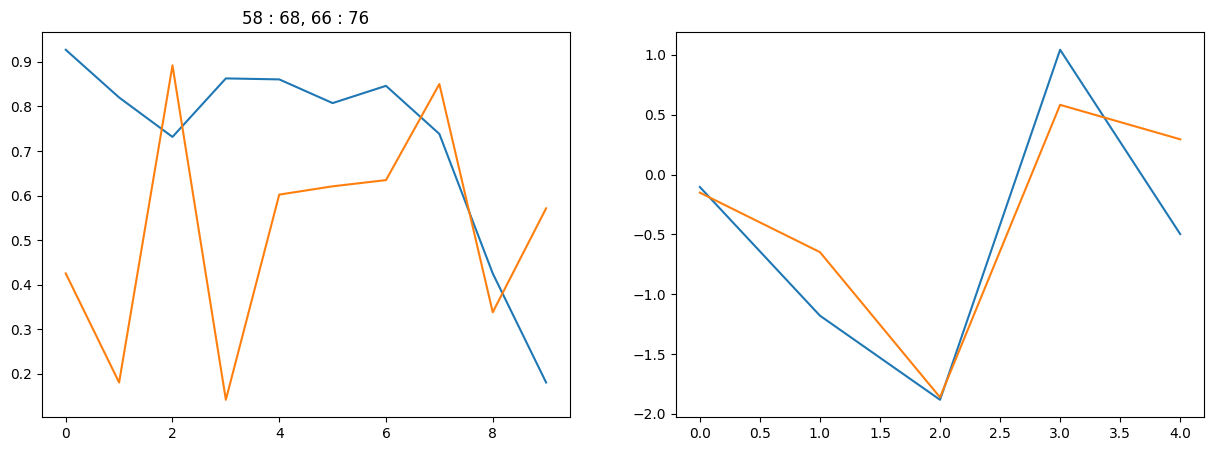

(10, 5) slice(None, 10, None)
0.28625714592657203


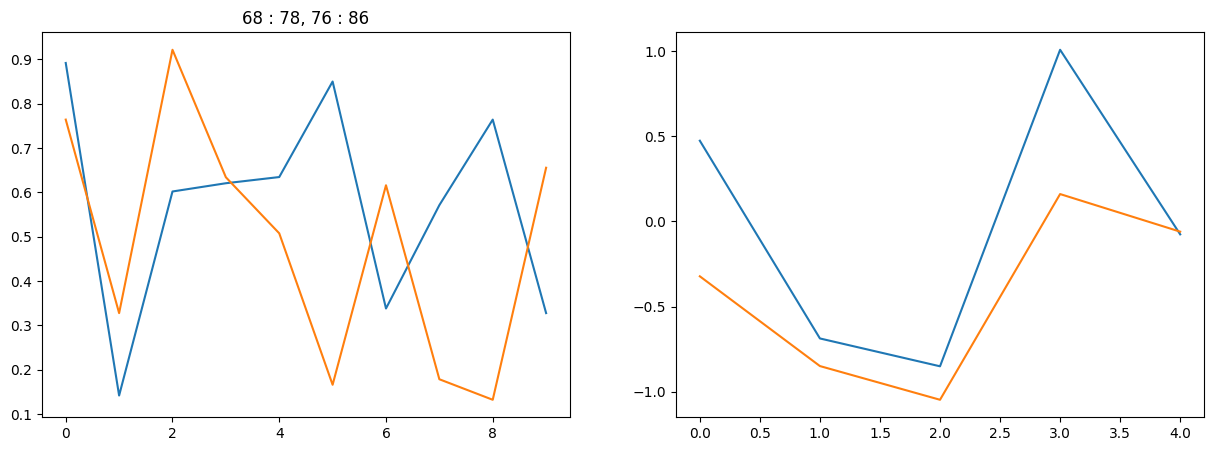

(10, 5) slice(None, 10, None)
0.7086262931312831


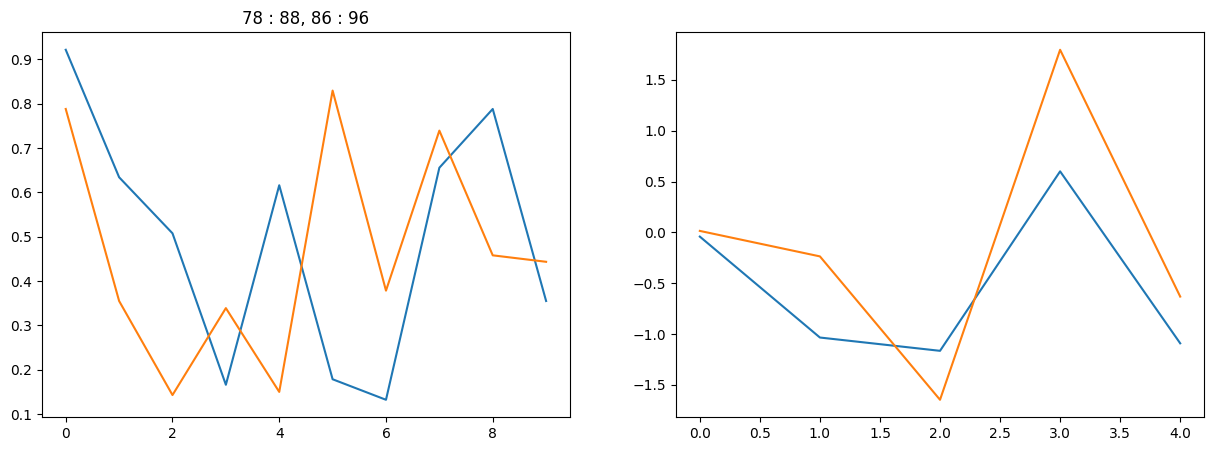

In [201]:
X = np.random.random((100,))
overlap = 2
window_size=10
X_part1 = X[:-(window_size - overlap)]
X_part2 = X[window_size - overlap:]
sigmoid = lambda x: 1/(1 + np.exp(-x))
paddings = 2
strides = window_size
for p, q, k in conviter(X_part2.shape, window_size, paddings, strides):
    # print(X_part1[p], X_part2[p], w[k, :].shape)
    # print((X_part1[p]@w[k, :]).shape, (X_part2[p]@w[k, :]).shape)
    print(w[k].shape, k)
    proj1 = (X_part1[p]@w[k, :])
    proj2 = (X_part2[p]@w[k, :])
    cov = ((proj1 - proj1.mean())*(proj2 - proj2.mean())).mean()
    fig, (ax1, ax2) = plt.subplots(1, 2)
    print(cov)
    ax1.plot(X_part1[p])
    ax1.plot(X_part2[p])
    ax1.set_title(
        f'{p.start} : {p.stop}, {p.start + window_size  - overlap} : {p.stop + window_size  - overlap}'
    )

    ax2.plot(proj1)
    ax2.plot(proj2)

    fig.set_size_inches(15, 5)
    plt.show()

In [73]:
compute_output_shape(X_part2.shape, window_size, paddings, strides//2)

(37,)